# Measuring the performance of RDataFrame

First, import all modules we are going to use.

In [2]:
import csv
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import ROOT
import sys
import time
import uproot

Welcome to JupyROOT 6.24/06


All three `runtime_measure` functions below return the runtime of the following operations:  
1. Accessing the TTree’s in the ROOT files  
2. Apply specific filters on the data to expose the invariant mass distribution of the B0s meson  
3. Convert the TBranch containing the mass of the meson to a `numpy` array  
 
The functions share two common parameters:  
- `path`: the path to the folder containing the ROOT files  
- `n_files`: is the number of file you want to process

## 1. Default runtime measurement
The function below measures the runtime when multiprocessing is not used. `mt` is a boolean value signifying whether implicit multithreading should be used (without a specified number of threads).

In [3]:
def runtime_measure(path, n_files, mt):
    ROOT.ROOT.DisableImplicitMT()
    if n_files == 0: return 0
    if mt: ROOT.ROOT.EnableImplicitMT()
    
    filenames = sorted(os.listdir(path))
    files_to_read = ROOT.std.vector('string')()
    for i in range(n_files):
        files_to_read.push_back(path + filenames[i])
    
    start_time = time.time()
    
    data = ROOT.RDataFrame("rootuple/CandidateTree", files_to_read)
    cut = data.Filter("candidate_charge == 0")\
          .Filter("candidate_cosAlpha > 0.99")\
          .Filter("candidate_vProb > 0.05")\
          .Filter("candidate_lxy / candidate_lxyErr > 3.0")\
          .Filter("ditrack_mass > 1.014")\
          .Filter("ditrack_mass < 1.024")\
          .Filter("candidate_vMass > 5.33")\
          .Filter("candidate_vMass < 5.40")
    np_array = cut.AsNumpy(["candidate_vMass"])
    
    return time.time() - start_time

## 2. Runtime measurement with implicit multithreading
In the function below, implicit multithreading is turned on. `n_threads` specifies the number of threads you want to used.

In [4]:
def runtime_measure_mt(path, n_files, n_threads):
    ROOT.ROOT.DisableImplicitMT()

    if n_files == 0: return 0
    if n_threads == 0: 
        return runtime_measure(path, n_files, False)
    
    ROOT.ROOT.EnableImplicitMT(n_threads)
    
    # Get paths to all the files to be read 
    filenames = sorted(os.listdir(path))
    files_to_read = ROOT.std.vector('string')()
    for i in range(n_files):
        files_to_read.push_back(path + filenames[i])
    
    # Measure runtime
    start_time = time.time()
    
    data = ROOT.RDataFrame("rootuple/CandidateTree", files_to_read)
    cut = data.Filter("candidate_charge == 0")\
          .Filter("candidate_cosAlpha > 0.99")\
          .Filter("candidate_vProb > 0.05")\
          .Filter("candidate_lxy / candidate_lxyErr > 3.0")\
          .Filter("ditrack_mass > 1.014")\
          .Filter("ditrack_mass < 1.024")\
          .Filter("candidate_vMass > 5.33")\
          .Filter("candidate_vMass < 5.40")
    np_array = cut.AsNumpy(["candidate_vMass"])
    
    return time.time() - start_time

## 3. Runtime measurement with multiprocessing

First, we need to split the data so that the workload is distributed as equally as possible among all subprocesses. Since file is the smallest unit of data we have, we can distribute `n_files` files to `n_processes` processes with the function below. It returns a list of vectors, each of which contains paths to the ROOT files that one subprocess will handle.

In [6]:
def partition(path, n_files, n_processes):
    filenames = sorted(os.listdir(path))
    partitions = []
    curr = 0
    for i in range(n_processes):
        if i >= n_files: break
        n_files_in_partition = n_files // n_processes if i >= n_files % n_processes else n_files // n_processes + 1
        files_to_read = ROOT.std.vector('string')()
        for j in range(n_files_in_partition):
            files_to_read.push_back(path + filenames[curr + j])
        curr += n_files_in_partition
        partitions.append(files_to_read)
    return partitions

For example, if we want to process 128 files with 30 subprocesses, the distribution will look like:

In [25]:
partitions = partition("../data/128_files/", 128, 30)
for p in partitions:
    print("[%d]" % (p.size()), end=" ")

[5] [5] [5] [5] [5] [5] [5] [5] [4] [4] [4] [4] [4] [4] [4] [4] [4] [4] [4] [4] [4] [4] [4] [4] [4] [4] [4] [4] [4] [4] 

A subprocess can then perform the operations mentioned previously by calling `to_numpy`. `files` is a vector containing paths to ROOT files, which is an element in the return value of `partition`. The function will add the `numpy` arrays containing the mass of the B0s meson to `result`, a list shared among all subprocesses. After the last subprocess finishes, all arrays in `result` will be concatenated together.

In [7]:
def to_numpy(files, result):
    if files.empty(): return
    data = ROOT.RDataFrame("rootuple/CandidateTree", files)
    cut = data.Filter("candidate_charge == 0")\
          .Filter("candidate_cosAlpha > 0.99")\
          .Filter("candidate_vProb > 0.05")\
          .Filter("candidate_lxy / candidate_lxyErr > 3.0")\
          .Filter("ditrack_mass > 1.014")\
          .Filter("ditrack_mass < 1.024")\
          .Filter("candidate_vMass > 5.33")\
          .Filter("candidate_vMass < 5.40")
    result.append(cut.AsNumpy(["candidate_vMass"])["candidate_vMass"])

Finally, `runtime_measure_mp` measures the runtime of **RDataFrame** using explicit multiprocessing.

In [8]:
def runtime_measure_mp(path, n_files, n_processes):
    ROOT.ROOT.DisableImplicitMT()
    if n_files == 0: return 0
    if n_processes == 0: return runtime_measure(path, n_files, False)
    start_time = time.time()
    partitions = partition(path, n_files, n_processes)
    processes = []
    result = multiprocessing.Manager().list()
    for files in partitions:
        p = multiprocessing.Process(target=to_numpy, args=[files, result])
        p.start()
        processes.append(p)
        
    for p in processes:
        p.join()
     
    np.concatenate(tuple(result))
    runtime = time.time() - start_time
    
    return runtime

## Run the measurements multiple times and save the results

`runtime_vs_variable` runs one of the `runtime_measure` functions above multiple times with varying number of processes, threads, or files, and then saves the result in a csv file. The file can then be used to produce a plot with the variable on the x-axis and runtime on the y-axis.

### List of parameters:
- `path`: path to the directory containing the ROOT files.
- `target_dir`: path to the directory where the resulting csv file will be stored.
- `measure_function`: reference to one of the `runtime_measure` functions above.
- `variable`: a string indicating the varying parameter. Can have the following values:
    - `processes`: the number of files is constant, while the number of subprocesses varies.
    - `threads`: the number of files is constant, while the number of threads varies.
    - `size`: the number of files varies. Implicit multithreading is used without specifying the number of threads.
    - `size_mp`: the number of files varies. Multiprocessing is used with a constant number of subprocesses.
    - `size_mt`: the number of files varies. Implicit multithreading is used with a constant number of threads.
- `step`: difference between 2 consective x-values.
- `n_loops`: the number of times each measurement is repeated.
- `var_max`: the maximum value of the variable (x).
- `constant`: the value of the constant. When parallelism is not used, this is not needed adn is set to `None`.

### Resulting csv file:
The name of the resulting csv files indicates the arguments passed to the function.
Examples:
- `runtime_vs_processes_128_128_4_20.csv`: the number of processes varies, the number of files is constant and equals 128, the maximum number of processes used is 128, the number of processes is incremented by 4 each time, and every measurement is repeated 20 times.
- `runtime_vs_size_mp_32_128_4_20.csv`: the number of files varies, multiprocessing is used with 32 subprocesses, the maximum number of files read is 128, the number of files is incremented by 4 each time, and every measurement is repeated 20 times.


In [1]:
def runtime_vs_variable(path, target_dir, measure_function, variable, step, n_loops, var_max, constant=None):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    result_path = ("%s/runtime_vs_%s_%d_%d_%d_%d.csv" % (target_dir, variable, constant, var_max, step, n_loops)) if constant else ("%s/runtime_vs_%s_%d_%d_%d.csv" % (target_dir, variable, var_max, step, n_loops))
    
    x = [a for a in range(0, var_max + step, step)]
    
    if not os.path.exists(result_path):
        with open(result_path, "w", newline="") as f:
            csv.writer(f).writerow(x)
    for n in range(n_loops):
        with open(result_path, "r") as f:
            if sum(1 for row in csv.reader(f)) == n_loops + 1: break
        y = [measure_function(*(path, i if "size" in variable else constant, constant if "size" in variable else i) if constant else (path, i, True)) for i in range(0, var_max + step, step)]
        with open(result_path, "a", newline="") as f:
            csv.writer(f).writerow(y)

## Example

First, let's set the path to the ROOT files and the target directory.

In [18]:
path = "../data/128_files/"
target_dir = "runtime_tests_rdf/128_files/wn-gpu-8-3-22"

Now we can run the measurements. This will take a long time, so it's recommended to run the Python file `runtime_measurement_rdf.py` in a screen instead.

In [17]:
# runtime_vs_variable(path, target_dir, runtime_measure_mp, "processes", 4, 20, 128, 32)
# runtime_vs_variable(path, target_dir, runtime_measure_mp, "size_mp", 4, 20, 128, 64)
# runtime_vs_variable(path, target_dir, runtime_measure, "size", 4, 20, 128)

Let's plot the result.

In [11]:
from ipynb.fs.defs.plot import plot

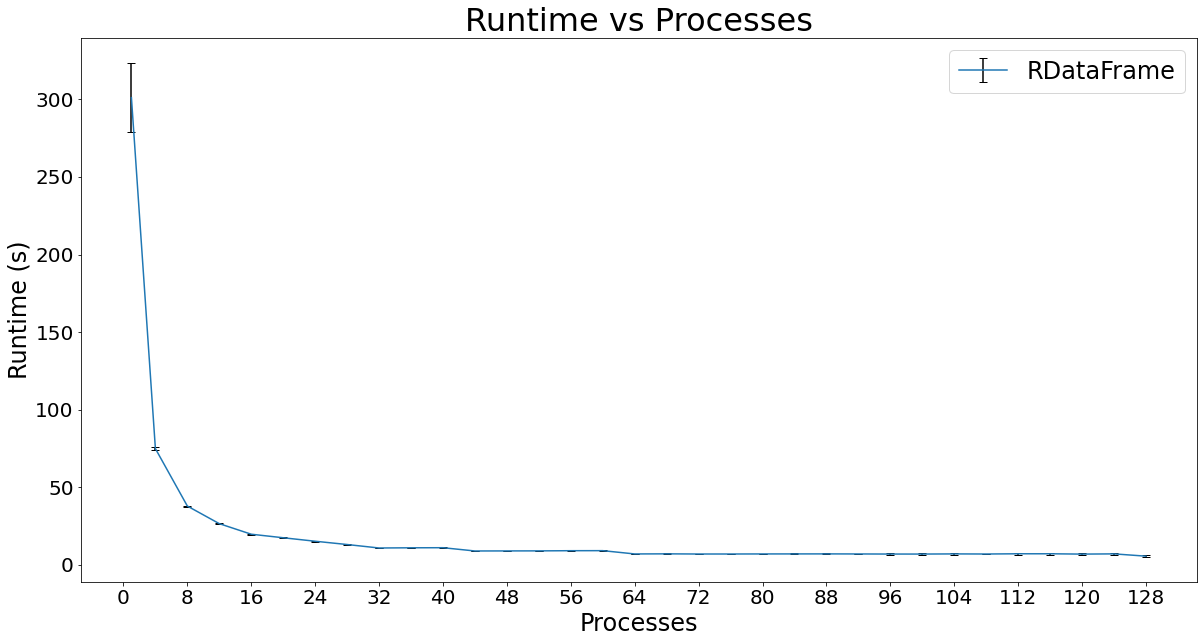

In [14]:
plot(path,
     'Runtime vs Processes',
     'Processes',
     'Runtime (s)',
     "runtime_tests_rdf/128_files/wn-gpu-8-3-22/runtime_vs_processes_128_128_4_20.csv",
     "RDataFrame",
     plot_type="errorbars"
    )

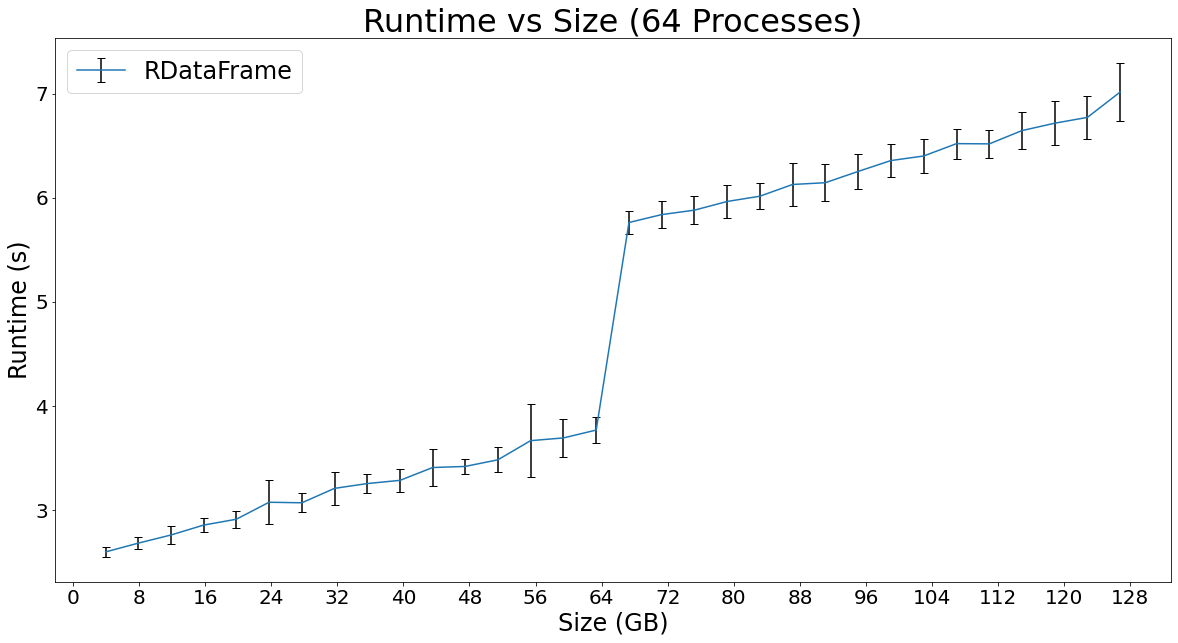

In [16]:
plot(path,
     'Runtime vs Size (64 Processes)',
     'Size (GB)',
     'Runtime (s)',
     "runtime_tests_rdf/128_files/wn-gpu-8-3-22/runtime_vs_size_mp_64_128_4_20.csv",
     "RDataFrame",
     plot_type="errorbars"
    )